# Step 2,3  - PreProcessing

Our initial analysis is very similar to the one performed for step one.<br>
The structure of the dataset is quite different this time: we can already see that the proportion of scores assigned by the users is not uniform, on the contrary more than half of the comments are assigning the best score to the product. This caused a lot of problems and we will discuss it further later.

In [1]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
del df_complete

stars= pd.get_dummies(df['overall'])
print(stars.sum())

five_stars = (df['overall']==5)*1.0

1     2791
2     3010
3     6789
4    16536
5    35580
dtype: int64


All the information was safely loaded.

In [2]:
df.isnull().any().any()

False

The number of comments for every product is not constant.

In [3]:
df['asin'].value_counts()

B0007NFL18    272
B000084T18    271
B00006690F    204
B00004T9UF    202
B00005YW4H    190
B0006ZQ9BS    185
B0000AGWFX    181
B00005O54Q    169
B00000163G    166
B00065XJ52    159
B000023VR6    158
B0000025RI    154
B000021YQV    154
B00008H2LB    152
B000002OPL    152
B000002NJS    145
B0000DD7LC    142
B0000TAZS8    141
B00000016W    135
B000002KH3    133
B000N2G3RY    132
B00008J4P5    125
B00000HZG9    125
B0000025F7    124
B00000J7JO    118
B00000FCBH    118
B00018D44U    116
B000001A5X    115
B00004UARR    114
B00004XOWM    112
             ... 
B007U732B0      5
B00005JXQS      5
B00004YLJW      5
B000002PCN      5
B00DN14LXA      5
B003TT03PQ      5
B00BFI7RV6      5
B000005S0D      5
B00004SST5      5
B00015V59Y      5
B001FX9QS8      5
B000001AAB      5
B00008L3VQ      5
B00000E9OE      5
B002NACYFE      5
B002O1QKGQ      5
B00137KS2O      5
B009RFIVXC      5
B0083EYA74      5
B00008ADQJ      5
B00136LEMS      5
B005HI7NP0      5
B003NFM44E      5
B0000027S9      5
B0049FGVV4

We can see that the number of products whose evaluations are low on average are not many. We noticed also that the average standard deviation of the evaluations is not high. Therefore, we expect bad evaluations to be mostly about the same products and, as a consequence, close in the tfidf space. We cannot say the same for the good evaluations. However, the standard deviation is not zero so the same product received different overall scores pretty often (as we could expect) and this will probably be difficult to interpret with the current setting of the model (tfidf).

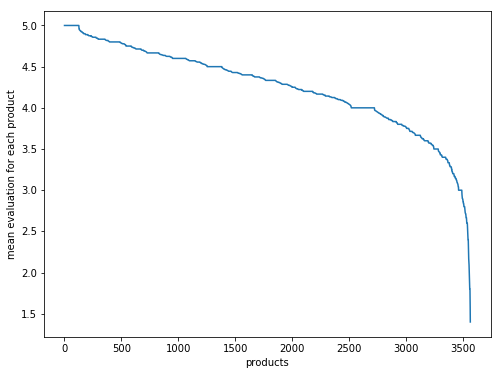

Average standard deviation of evaluations:  0.8610549537271677


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# we ordered products by average evaluation so that the graph is easier to understand
united = df.groupby(['asin'], as_index=False)['overall'].agg([np.mean, np.std])
united_sorted=united.sort_values('mean',ascending=False)


plt.figure(figsize=(8, 6))
plt.plot(np.arange(united_sorted.shape[0]), united_sorted.ix[:,0])
plt.xlabel('products')
plt.ylabel('mean evaluation for each product')
plt.show()

print('Average standard deviation of evaluations: ',united.ix[:,1].mean())

We wanted to give a visual representation of the tfidf space as in the previous step. We will run the same preprocessing steps and will plot the 3D represantations of the data after dimensionality reduction through PCA (both normalized and not).

In [5]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:2000,:]
del df_complete

five_stars = df['overall']

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))

In [6]:
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined
print ('original: ',documents[tester], '\n')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
original:  A clasically styled and introverted album  Memory of Trees is a masterpiece of subtlety   Many of the songs have an endearing shyness to them   soft piano and a lovely  quiet voice   But within every introvert is an inferno  and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power If you ve never heard Enya before  you might want to start with one of her more popularized works  like Watermark  just to play it safe   But if you re already a fan  then your collection is not complete without this beautiful work of musical art  



In [7]:
# removing stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

print ('tokenize and remove stop words: ',documents_no_stop[tester], '\n')
del documents

tokenize and remove stop words:  ['clasically', 'styled', 'introverted', 'album', 'memory', 'trees', 'masterpiece', 'subtlety', 'songs', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'introvert', 'inferno', 'enya', 'lets', 'explode', 'couple', 'songs', 'absolutely', 'burst', 'expected', 'raw', 'power', 've', 'heard', 'enya', 'want', 'start', 'popularized', 'works', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 



In [8]:
# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

print ('remove unique words: ',documents_no_stop_no_unique[tester], '\n')
del documents_no_stop

remove unique words:  ['styled', 'introverted', 'album', 'memory', 'trees', 'masterpiece', 'subtlety', 'songs', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'enya', 'lets', 'explode', 'couple', 'songs', 'absolutely', 'burst', 'expected', 'raw', 'power', 've', 'heard', 'enya', 'want', 'start', 'popularized', 'works', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 



In [9]:
# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

print ('remove numerics: ',documents_no_stop_no_unique_no_numeric[tester], '\n')
del documents_no_stop_no_unique

remove numerics:  ['styled', 'introverted', 'album', 'memory', 'trees', 'masterpiece', 'subtlety', 'songs', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'enya', 'lets', 'explode', 'couple', 'songs', 'absolutely', 'burst', 'expected', 'raw', 'power', 've', 'heard', 'enya', 'want', 'start', 'popularized', 'works', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 



In [10]:
# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

print ('lemmatize: ',documents_no_stop_no_unique_no_numeric_lemmatize[tester], '\n')
del documents_no_stop_no_unique_no_numeric

lemmatize:  ['styled', 'introverted', 'album', 'memory', 'tree', 'masterpiece', 'subtlety', 'song', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'enya', 'let', 'explode', 'couple', 'song', 'absolutely', 'burst', 'expected', 'raw', 'power', 've', 'heard', 'enya', 'want', 'start', 'popularized', 'work', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 



In [11]:
import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

print ('no english: ',documents_no_stop_no_unique_no_numeric_lemmatize_english[tester], '\n')
del documents_no_stop_no_unique_no_numeric_lemmatize


no english:  ['styled', 'introverted', 'album', 'memory', 'tree', 'masterpiece', 'subtlety', 'song', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'let', 'explode', 'couple', 'song', 'absolutely', 'burst', 'expected', 'raw', 'power', 'heard', 'want', 'start', 'popularized', 'work', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 



In [12]:
# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english
print (len(ready_corpus))

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)


2001
Dictionary(6780 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)


In [13]:
# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

i = 0
for doc in corpus_bow:
    print(doc)
    print('')
    i+=1
    if i > 5: break


[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]

[(2, 1), (3, 1), (11, 1), (19, 1), (28, 2), (30, 1), (46, 1), (53, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)]

[(2, 1), (9, 1), (11, 1), (15, 1), (28, 1), (37, 1), (40, 1), (41, 1), (48, 1), (77, 1), (85, 1), (86, 2), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (

In [14]:
import os
from gensim import corpora, models, matutils
from sklearn.model_selection import train_test_split

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

print(len(corpus_tfidf.corpus))
for doc in corpus_tfidf:
    print(doc)
    break


2001
[(0, 0.07056553266410953), (1, 0.08476739393956724), (2, 0.22233928381083248), (3, 0.25472443703968), (4, 0.06871293882441185), (5, 0.04578653586302873), (6, 0.09727747163127466), (7, 0.16494510619978855), (8, 0.15306776077167009), (9, 0.03052073235626142), (10, 0.034212853752734286), (11, 0.018992672857966738), (12, 0.10927643961253536), (13, 0.1856647300583241), (14, 0.05870653677857523), (15, 0.060364369924714716), (16, 0.12564835065179233), (17, 0.1189104008026482), (18, 0.16494510619978855), (19, 0.05880764957221604), (20, 0.12917407358779623), (21, 0.25651040494088184), (22, 0.18000045906249645), (23, 0.17130613324965543), (24, 0.12100119146997315), (25, 0.1679663277611467), (26, 0.1062832451055332), (27, 0.060364369924714716), (28, 0.050223564368069754), (29, 0.03482472849082276), (30, 0.02305151372910964), (31, 0.20613086174047818), (32, 0.15964968651289377), (33, 0.09497706529099248), (34, 0.11758942492007396), (35, 0.41226172348095635), (36, 0.135328592845872), (37, 0.02

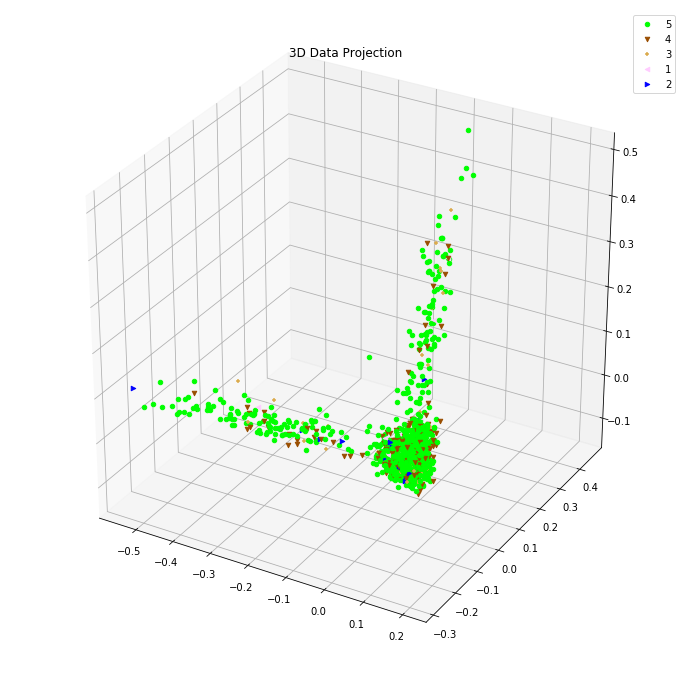

In [15]:
# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

# visualize the tf-idf corpus using kernel PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

kpca = KernelPCA(n_components = 3, kernel="cosine", random_state=seed)
corpus_tfidf_kpca = kpca.fit_transform(sparse_corpus_tfidf_transpose)

#RENAMED FOR EASE
X = corpus_tfidf_kpca

#CREATE DICTIONARY TO ASSIGN COLORS
categories = five_stars.unique()

#REINDEX OUTPUT TO COMPARE WITH LABELS
reindexed = five_stars.reset_index()

#CREATE DICTIONARY TO ASSIGN VALUES TO OCCURRENCE VECTOR AND COLORS
together = zip(categories,np.arange(0,5))
locator = dict(together)
occurred =  np.zeros(5)

reds  = [0, 0.6, 0.86,   1,  0]
greens =[1, 0.3, 0.67, 0.8,  0]
blues = [0,   0,  0.3,   1,  1]   

markers = ['o', 'v', '+', '<', '>']
colors = pd.DataFrame(reds, columns = ['Reds'])
colors['Greens'] = greens
colors['Blues'] = blues

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(0,len(five_stars)):

    index = locator[reindexed.ix[i,1]]
    
    if(occurred[locator[reindexed.ix[i,1]]] == 0):
        
        occurred[locator[reindexed.ix[i,1]]] = 1
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:], label = reindexed.ix[i,1], marker=markers[index])
        
    else:
        #NO LABEL IF ALREADY EXISTING
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:],marker=markers[index])
        
plt.legend()
plt.title("3D Data Projection")

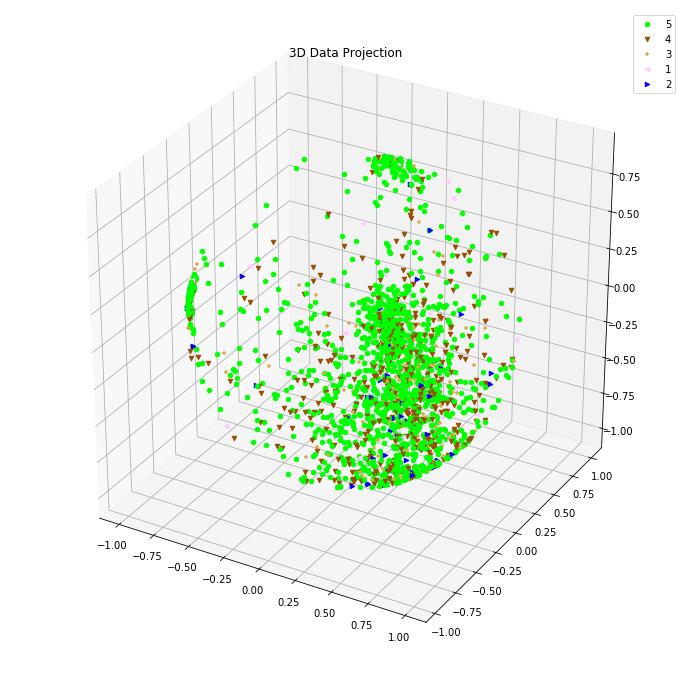

In [16]:
from sklearn.preprocessing import Normalizer

#RENAMED FOR EASE
normalizar=Normalizer()
X = normalizar.fit_transform(corpus_tfidf_kpca)

#CREATE DICTIONARY TO ASSIGN COLORS
categories = five_stars.unique()

#REINDEX OUTPUT TO COMPARE WITH LABELS
reindexed = five_stars.reset_index()

#CREATE DICTIONARY TO ASSIGN VALUES TO OCCURRENCE VECTOR AND COLORS
together = zip(categories,np.arange(0,5))
locator = dict(together)
occurred =  np.zeros(5)

reds  = [0, 0.6, 0.86,   1,  0]
greens =[1, 0.3, 0.67, 0.8,  0]
blues = [0,   0,  0.3,   1,  1]   

markers = ['o', 'v', '+', '<', '>']
colors = pd.DataFrame(reds, columns = ['Reds'])
colors['Greens'] = greens
colors['Blues'] = blues

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(0,len(five_stars)):

    index = locator[reindexed.ix[i,1]]
    
    if(occurred[locator[reindexed.ix[i,1]]] == 0):
        
        occurred[locator[reindexed.ix[i,1]]] = 1
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:], label = reindexed.ix[i,1], marker=markers[index])
        
    else:
        #NO LABEL IF ALREADY EXISTING
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:],marker=markers[index])
        
plt.legend()
plt.title("3D Data Projection")

It is clear that most of the reviwers gave 5 stars to the products and that that might influence heavily our methods later on. It is also difficult to find any 'pure' cluster of evaluations. For this reason we decided to try another approach and looked for the 'sentiment' words in our comments.

In [26]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:2000,:]
del df_complete
five_stars = df['overall']

# We are not removing all the special characters.
# NLTK will handle the special characters within the functions, they are used to
# assess what words are influenced by negative terms (e.g. 'I do not like it. It is bad!' 
# will consider the 'like' as negated because it is between the 'not' and the '.',
# 'bad' will be considered as normal, for the sentence 'I like it. It is not bad!'
# it will do the opposite). We will only keep the special characters that NLTK uses: ^[.:;!?]
# Since sometimes there was no space after them we are adding it.
df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('^','^ ').replace('[','[ ').replace('.','. ')\
                           .replace(',',', ').replace(':',': ').replace(';','; ')\
                           .replace("]",'] ').replace('!','! ').replace('?','? ')\
                           .replace('$',' ').replace("<",' ').replace('>',' ')\
                           .replace('-',' ').replace('/',' ').replace('#',' '))
    
from nltk.stem import WordNetLemmatizer

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined
print ('original: ',documents[tester], '\n')

original:  A clasically styled and introverted album,  Memory of Trees is a masterpiece of subtlety.   Many of the songs have an endearing shyness to them   soft piano and a lovely,  quiet voice.   But within every introvert is an inferno,  and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power. If you've never heard Enya before,  you might want to start with one of her more popularized works,  like Watermark,  just to play it safe.   But if you're already a fan,  then your collection is not complete without this beautiful work of musical art.  



In [27]:
# Tokenize words
from nltk.tokenize import word_tokenize
from nltk import download
download('punkt')

documents_tokenized = [word_tokenize(document) for document in documents]

print ('tokenize: ',documents_tokenized[tester], '\n')


[nltk_data] Downloading package punkt to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
tokenize:  ['A', 'clasically', 'styled', 'and', 'introverted', 'album', ',', 'Memory', 'of', 'Trees', 'is', 'a', 'masterpiece', 'of', 'subtlety', '.', 'Many', 'of', 'the', 'songs', 'have', 'an', 'endearing', 'shyness', 'to', 'them', 'soft', 'piano', 'and', 'a', 'lovely', ',', 'quiet', 'voice', '.', 'But', 'within', 'every', 'introvert', 'is', 'an', 'inferno', ',', 'and', 'Enya', 'lets', 'that', 'fire', 'explode', 'on', 'a', 'couple', 'of', 'songs', 'that', 'absolutely', 'burst', 'with', 'an', 'expected', 'raw', 'power', '.', 'If', 'you', "'ve", 'never', 'heard', 'Enya', 'before', ',', 'you', 'might', 'want', 'to', 'start', 'with', 'one', 'of', 'her', 'more', 'popularized', 'works', ',', 'like', 'Watermark', ',', 'just', 'to', 'play', 'it', 'safe', '.', 'But', 'if', 'you', "'re", 'already', 'a', 'fan', ',', 'then', 'your', 'collection', 'is', '

In [28]:
# lemmattizing tokens (better than stemming by taking word context into account)
documents_tokenized_lemmatized = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_tokenized]

print ('lemmatize: ',documents_tokenized_lemmatized[tester], '\n')


lemmatize:  ['A', 'clasically', 'styled', 'and', 'introverted', 'album', ',', 'Memory', 'of', 'Trees', 'is', 'a', 'masterpiece', 'of', 'subtlety', '.', 'Many', 'of', 'the', 'song', 'have', 'an', 'endearing', 'shyness', 'to', 'them', 'soft', 'piano', 'and', 'a', 'lovely', ',', 'quiet', 'voice', '.', 'But', 'within', 'every', 'introvert', 'is', 'an', 'inferno', ',', 'and', 'Enya', 'let', 'that', 'fire', 'explode', 'on', 'a', 'couple', 'of', 'song', 'that', 'absolutely', 'burst', 'with', 'an', 'expected', 'raw', 'power', '.', 'If', 'you', "'ve", 'never', 'heard', 'Enya', 'before', ',', 'you', 'might', 'want', 'to', 'start', 'with', 'one', 'of', 'her', 'more', 'popularized', 'work', ',', 'like', 'Watermark', ',', 'just', 'to', 'play', 'it', 'safe', '.', 'But', 'if', 'you', "'re", 'already', 'a', 'fan', ',', 'then', 'your', 'collection', 'is', 'not', 'complete', 'without', 'this', 'beautiful', 'work', 'of', 'musical', 'art', '.'] 



In [29]:
from nltk.sentiment.util import mark_negation

documents_tokenized_lemmatized_negated = [mark_negation(document) for document in documents_tokenized_lemmatized]

ready_corpus=documents_tokenized_lemmatized_negated


In [30]:
download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

# we consider only sentiment words, opinion_lexicon icludes already mispelled sentiment words,
# so we did not use the enchant library this time.
sentiment_words= opinion_lexicon.words()
sentiment_words_negated= [word+'_NEG' for word in sentiment_words]

sentiment_features=sentiment_words+sentiment_words_negated

from gensim import corpora, models, matutils
# build the dictionary
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
Dictionary(27627 unique tokens: ['It', "'s", 'hard', 'to', 'believe']...)


In [31]:
from nltk.sentiment import SentimentAnalyzer

sentiment_analizer= SentimentAnalyzer()
list_all_words=sentiment_analizer.all_words(ready_corpus)

used_sentiment_words=list(set(sentiment_features).intersection(list_all_words))

# determine which tokens to keep
good_ids = [dictionary.token2id[word] for word in used_sentiment_words]
        
dictionary.filter_tokens(good_ids=good_ids)
dictionary.compactify()
print(dictionary)
# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

i = 0
for doc in corpus_bow:
    print(doc)
    print('')
    i+=1
    if i > 5: break


Dictionary(3194 unique tokens: ['hard', 'well', 'great', 'creative', 'melancholy']...)
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]

[(13, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1)]

[(24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]

[(2, 1), (6, 1), (31, 1), (32, 1), (33, 1), (34, 2)]

[(1, 1), (2, 2), (6, 3), (31, 2), (32, 3), (33, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 3), (41, 1), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)]

[(1, 1), (6, 7), (7, 2), (11, 3), (12, 1), (13, 1), (21, 1), (31, 2), (32, 3), (45, 3), (46, 1), (49, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (8

In [32]:
from sklearn.model_selection import train_test_split

# should we put only train here?
tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

print(len(corpus_tfidf.corpus))
for doc in corpus_tfidf:
    print(doc)
    break


2001
[(0, 0.13641750511110315), (1, 0.08668040152576793), (2, 0.06891714712705162), (3, 0.2209824959995628), (4, 0.21817602706419426), (5, 0.31737311845257105), (6, 0.04911245283015077), (7, 0.1842856577065867), (8, 0.36492151130463407), (9, 0.4265730876107794), (10, 0.3098796460723948), (11, 0.09688558640364309), (12, 0.23386568177217562), (13, 0.22705519165354732), (14, 0.4265730876107794), (15, 0.16382273100008699)]


In [33]:
# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()


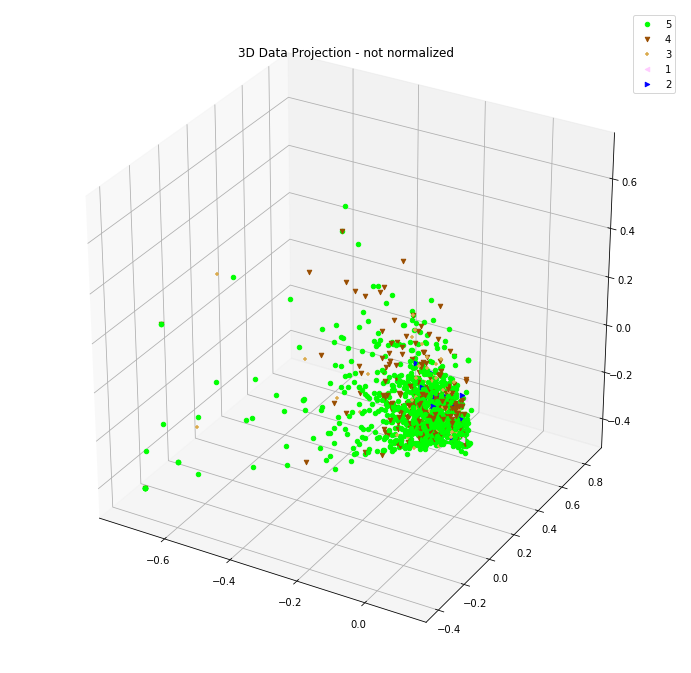

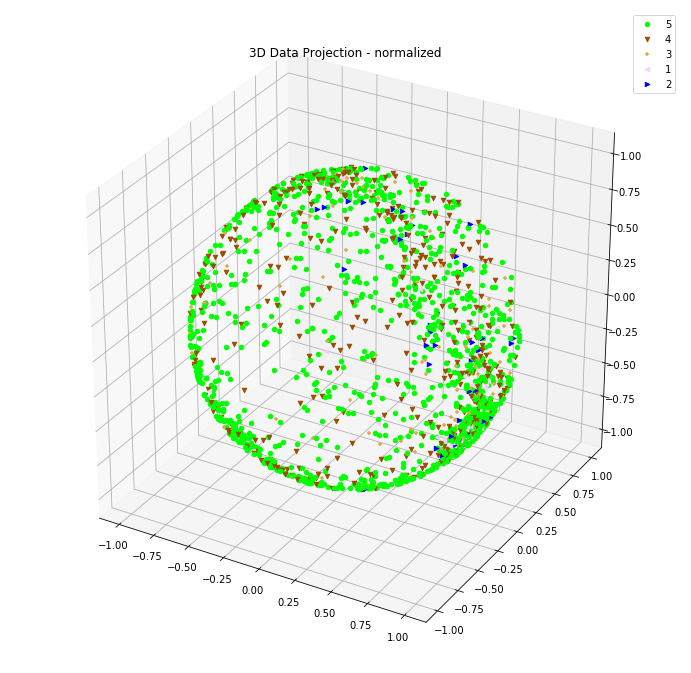

In [34]:
# visualize the tf-idf corpus using kernel PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

kpca = KernelPCA(n_components = 3, kernel="cosine", random_state=seed)
corpus_tfidf_kpca = kpca.fit_transform(sparse_corpus_tfidf_transpose)

from sklearn.preprocessing import Normalizer

#RENAMED FOR EASE
X = corpus_tfidf_kpca

#CREATE DICTIONARY TO ASSIGN COLORS
categories = five_stars.unique()

#REINDEX OUTPUT TO COMPARE WITH LABELS
reindexed = five_stars.reset_index()

#CREATE DICTIONARY TO ASSIGN VALUES TO OCCURRENCE VECTOR AND COLORS
together = zip(categories,np.arange(0,5))
locator = dict(together)
occurred =  np.zeros(5)

reds  = [0, 0.6, 0.86,   1,  0]
greens =[1, 0.3, 0.67, 0.8,  0]
blues = [0,   0,  0.3,   1,  1]   

markers = ['o', 'v', '+', '<', '>']
colors = pd.DataFrame(reds, columns = ['Reds'])
colors['Greens'] = greens
colors['Blues'] = blues

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(0,len(five_stars)):

    index = locator[reindexed.ix[i,1]]
    
    if(occurred[locator[reindexed.ix[i,1]]] == 0):
        
        occurred[locator[reindexed.ix[i,1]]] = 1
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:], label = reindexed.ix[i,1], marker=markers[index])
        
    else:
        #NO LABEL IF ALREADY EXISTING
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:],marker=markers[index])
        
plt.legend()
plt.title("3D Data Projection - not normalized")


#RENAMED FOR EASE
normalizar=Normalizer()
X = normalizar.fit_transform(corpus_tfidf_kpca)

#CREATE DICTIONARY TO ASSIGN COLORS
categories = five_stars.unique()

#REINDEX OUTPUT TO COMPARE WITH LABELS
reindexed = five_stars.reset_index()

#CREATE DICTIONARY TO ASSIGN VALUES TO OCCURRENCE VECTOR AND COLORS
together = zip(categories,np.arange(0,5))
locator = dict(together)
occurred =  np.zeros(5)

reds  = [0, 0.6, 0.86,   1,  0]
greens =[1, 0.3, 0.67, 0.8,  0]
blues = [0,   0,  0.3,   1,  1]   

markers = ['o', 'v', '+', '<', '>']
colors = pd.DataFrame(reds, columns = ['Reds'])
colors['Greens'] = greens
colors['Blues'] = blues

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(0,len(five_stars)):

    index = locator[reindexed.ix[i,1]]
    
    if(occurred[locator[reindexed.ix[i,1]]] == 0):
        
        occurred[locator[reindexed.ix[i,1]]] = 1
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:], label = reindexed.ix[i,1], marker=markers[index])
        
    else:
        #NO LABEL IF ALREADY EXISTING
        ax.scatter(X[i,0], X[i,1], X[i,2], color = colors.ix[index,:],marker=markers[index])
        
plt.legend()
plt.title("3D Data Projection - normalized")


The separation is not as neat as it was in step 1 but at least it looks better than in the previous attempt.

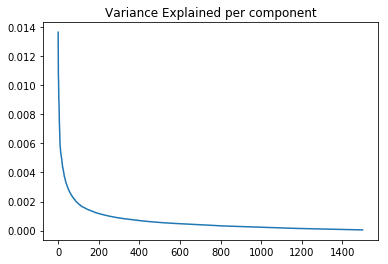

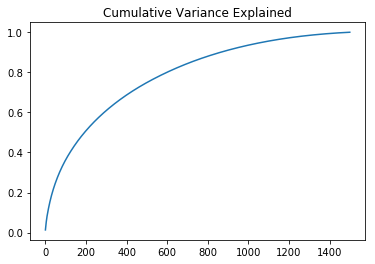

In [38]:
from sklearn.decomposition import KernelPCA
import numpy as np
reducer= KernelPCA(n_components = 1500 , kernel="cosine", random_state=seed)
corpus_tfidf_kpca = reducer.fit_transform(sparse_corpus_tfidf_transpose)

# np.var does not accept as inputs sparse matrixes so we approximated the total variance 
# with the variance of the first 1500 principal components, this will not be the exact
# amount of explained variance but what we are interested about is the shape of the curve.
explained_variance = np.var(corpus_tfidf_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

cum_explained_variance=np.cumsum(explained_variance_ratio)

plt.figure()
plt.plot(explained_variance_ratio)
plt.title('Variance Explained per component')

plt.figure()
plt.plot(cum_explained_variance)
plt.title('Cumulative Variance Explained')

The cumulative explained variance has a nicer trend compared to the one of step 1. A dimensionality reduction technique might be more efficient in this case because the curve flattens quickly. However, the reduced 'computational budget' of our laptop will present us with the trade off between more data and more preprocessing that we have already found in the previous step.<br><br>

Finally, we wanted to see how our sentiment analysis performed against a more classical library. We applied Vader sentiment analysis tools to our data. The output of this algorithm are 3 scores between 0 and 1 assigned to every comment: negative, neutral and positive. As their name intuitively suggests they are exactly the kind of score that we need. The fourth score, 'compound', is just a summary of the other 3.

In [8]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:10,:]
del df_complete
five_stars = df['overall']


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
i=0
for sentence in df.ix[:,2]:
    print(sentence[:90]+'...')
    ss = analyzer.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\nOverall score: ', five_stars[i])
    i=i+1
    print()

It's hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the ...
compound: 0.975, neg: 0.032, neu: 0.788, pos: 0.18, 
Overall score:  5

A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety.  ...
compound: 0.9242, neg: 0.073, neu: 0.727, pos: 0.199, 
Overall score:  5

I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shep...
compound: 0.9837, neg: 0.0, neu: 0.698, pos: 0.302, 
Overall score:  5

This is the third review of an irish album I write today (the others were Cranberries) and...
compound: 0.9819, neg: 0.0, neu: 0.724, pos: 0.276, 
Overall score:  5

Enya, despite being a successful recording artist, doesn't have the broad appeal as other ...
compound: 0.9982, neg: 0.028, neu: 0.824, pos: 0.149, 
Overall score:  4

Who knows why I initially considered this to be a duff album by the woman with the most be...
compound: 0.9983, neg: 0.04, neu: 0.791, pos: 0.17, 
Overall score:  5



We used the 3 scores assigned to every comment instead of the tfidf representation computed earlier. The performances of the methods were quite impressive considering that they were only using three features, however the learning curve was not as steep and, for large training sets, the model developped above achieved better results.

## Conclusion

We really wanted to try something different form the setting of step one, but the test scores for the preprocessing done in the first way were clearly better than for the other two. Therefore, we used it again. The other two methods are ignoring a lot of information coming from 'non-sentiment' words. It might be that with really huge datasets they would perform better because the dictionary creation is easier, especially for Vader tools, where it has already been done and one just needs to compute the scores.